## Greedy Navigation

Navigate the graph by greedily choosing the article with the smallest cosine distance to the target article.

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm



In [2]:
articles_df = pd.read_feather("Data/dataframes/article_dataframe_with_embeddings.feather")
filtered_paths_df = pd.read_feather('Data/dataframes/length_filt_finished_paths.feather')
paths_df = pd.read_feather('Data/dataframes/paths.feather')

In [3]:
articles_df.head(1)

,article,article_unrendered_unicode,category,linkSource,linkTarget,distances,plain_text,incoming_links,num_hyperlinks,num_characters,hyperlink_density,embeddings
0,Áedán_mac_Gabráin,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,[subject.History.British_History.British_Histo...,Áedán_mac_Gabráin,"[Bede, Columba, Dál_Riata, Great_Britain, Irel...","{'10th_century': 3.0, '11th_century': 3.0, '12...",#copyright\n\nÁedán mac Gabráin\n\n2007 Sch...,0,11,11612,0.000947,"[-0.12923911213874817, 0.02362193539738655, -0..."


In [4]:
filtered_paths_df.head(1)

,hashedIpAddress,timestamp,durationInSec,path,rating,finished,failure_reason,start_article,target_article,identifier,full_path,simplified_path,distance,full_path_length,simplified_path_length
0,0935d79e398bbc10,1323114272,203,Theatre;India;Bay_of_Bengal;Indian_Ocean;Afric...,NaN,True,None,Theatre,Zebra,38072,"[Theatre, India, Bay_of_Bengal, Indian_Ocean, ...","[Theatre, India, Bay_of_Bengal, Indian_Ocean, ...",3.0,8,7


In [5]:
paths_df.head(1)

,hashedIpAddress,timestamp,durationInSec,path,rating,finished,failure_reason,start_article,target_article,identifier,full_path,simplified_path,distance,full_path_length,simplified_path_length
0,6a3701d319fc3754,1297740409,166,14th_century;15th_century;16th_century;Pacific...,NaN,True,None,14th_century,African_slave_trade,48,"[14th_century, 15th_century, 16th_century, Pac...","[14th_century, 15th_century, 16th_century, Pac...",3.0,8,8


### Before running this, let's do some optimizations.

In [6]:
# Store the graph, embeddings in dictionary
next_article_dict  = {}
embedding_dict  = {}

for index, row in articles_df.iterrows():
    next_article_dict[row['article']] = row['linkTarget']
    embedding_dict[row['article']] = row['embeddings']

In [11]:
# Store the embedding distances
from sklearn.metrics.pairwise import cosine_distances

all_article_names = list(set(articles_df['article'].to_list()))
num_unique_articles = len(all_article_names)


index_lookup = {string: index for index, string in enumerate(all_article_names)}

index_lookup['Long_peper'] = index_lookup['Long_pepper']
embedding_dict['Long_peper'] = embedding_dict["Long_pepper"]
# Create a matrix to store the embeddings
embeddings_matrix = np.zeros((num_unique_articles, len(embedding_dict[all_article_names[0]])))

# Populate the embeddings matrix with the correct embeddings
for article, index in index_lookup.items():
    embeddings_matrix[index] = embedding_dict[article]

# Compute the cosine distances between all embeddings
distance_matrix = cosine_distances(embeddings_matrix)

# Function to look up the distance using the indices from index_lookup
def get_distance(article1, article2):
    index1 = index_lookup[article1]
    index2 = index_lookup[article2]
    return distance_matrix[index1, index2]

# Example usage:
# distance = get_distance("article1_name", "article2_name")


In [ ]:
def export_distance_matrix_to_csv(distance_matrix, index_lookup, output_file='distance_matrix.csv'):
    """
    Export the distance matrix to a CSV file with columns: StartArticle, EndArticle, Distance
    
    Parameters:
    distance_matrix: numpy array containing the pairwise distances
    index_lookup: dictionary mapping article names to matrix indices
    output_file: string, path to output CSV file (default: 'distance_matrix.csv')
    """
    import pandas as pd
    
    # Create reverse lookup dictionary (index to article name)
    reverse_lookup = {v: k for k, v in index_lookup.items()}
    
    # Lists to store the data
    start_articles = []
    end_articles = []
    distances = []
    
    # Iterate through the matrix and collect all pairs
    for i in range(len(distance_matrix)):
        for j in range(len(distance_matrix)):
            # Get article names from indices
            start_article = reverse_lookup[i]
            end_article = reverse_lookup[j]
            
            # Skip self-distances if desired
            # if i == j:
            #     continue
            
            start_articles.append(start_article)
            end_articles.append(end_article)
            distances.append(distance_matrix[i, j])
    
    # Create DataFrame
    df = pd.DataFrame({
        'StartArticle': start_articles,
        'EndArticle': end_articles,
        'Distance': distances
    })
    
    # Save to CSV
    df.to_csv(output_file, index=False)
    
    print(f"Distance matrix exported to {output_file}")
    return df

In [8]:
print("Distance matrix shape:", distance_matrix.shape)


Distance matrix shape: (4604, 4604)


In [ ]:
# import numpy as np

# # Create a DataFrame to store the results
# rows = []

# # Generate the data for the CSV
# for start_article, start_idx in index_lookup.items():
#     for end_article, end_idx in index_lookup.items():
#         distance = distance_matrix[start_idx, end_idx]
#         rows.append({"Start": start_article, "End": end_article, "Distance": distance})

# # Create the DataFrame
# csv_df = pd.DataFrame(rows)

# # Save the DataFrame to a CSV file
# csv_df.to_csv('article_distances.csv', index=False)

# print("CSV file 'article_distances.csv' created successfully!")

: 

In [8]:
filtered_paths_list = []

for index, row in filtered_paths_df.iterrows():
    filtered_paths_list.append((row['start_article'], row['target_article']))


In [ ]:
articles_df[articles_df['article'] == "Zebra"]['distances'].values[0]

{'10th_century': 2.0,
 '11th_century': 3.0,
 '12th_century': 3.0,
 '13th_century': 3.0,
 '14th_century': 2.0,
 '15th_Marine_Expeditionary_Unit': 4.0,
 '15th_century': 3.0,
 '16_Cygni': 6.0,
 '16_Cygni_Bb': 7.0,
 '16th_century': 3.0,
 '1755_Lisbon_earthquake': 3.0,
 '17th_century': 2.0,
 '1896_Summer_Olympics': 3.0,
 '18th_century': 2.0,
 '1928_Okeechobee_Hurricane': 4.0,
 '1973_oil_crisis': 3.0,
 '1980_eruption_of_Mount_St._Helens': 4.0,
 '1997_Pacific_hurricane_season': None,
 '19th_century': 2.0,
 '1_Ceres': 4.0,
 '1st_century': 3.0,
 '1st_century_BC': 3.0,
 '2-6-0': 5.0,
 '2-8-0': 4.0,
 '2003_Atlantic_hurricane_season': 5.0,
 '2004_Atlantic_hurricane_season': 4.0,
 '2004_Indian_Ocean_earthquake': 2.0,
 '2005_Atlantic_hurricane_season': 4.0,
 '2005_Hertfordshire_Oil_Storage_Terminal_fire': None,
 '2005_Kashmir_earthquake': 3.0,
 '2005_Lake_Tanganyika_earthquake': None,
 '2005_Sumatra_earthquake': 3.0,
 '20th_century': 2.0,
 '21st_century': 3.0,
 '2nd_century': 3.0,
 '3_Juno': 4.0,
 '

In [10]:
###  Play a list of paths with embedding lists.


def play_path_list(path_list: list[tuple]):
    # Placeholder for storing all paths
    paths_data = []
    dead_ends = 0

    dead_end_articles = set()

    # Iterate over all paths with a progress bar
    for path_start, path_end in tqdm(path_list, desc="Processing paths"):
        if not path_end in all_article_names:
            continue
        current_article = path_start
        path = [current_article]
        visited_articles = set(path)  # Keep track of visited articles

        while current_article != path_end:
            # Get the list of next articles excluding already visited ones
            next_articles = [
                article
                for article in next_article_dict[current_article]
                if article not in visited_articles
            ]

            if not next_articles:
                # If there are no unvisited next articles, break to avoid infinite loop
                # print(f"Dead-end reached from {current_article}.")
                dead_end_articles.add(current_article)
                dead_ends += 1
                break

            # Compute distances to the target for all valid next articles
            distances = [get_distance(article, path_end) for article in next_articles]
            # Find the next article with the minimum distance
            current_article = next_articles[np.argmin(distances)]
            path.append(current_article)
            visited_articles.add(current_article)  # Add the article to the visited set

        # Append path data to the list
        paths_data.append(
            {
                "start_article": path_start,
                "target_article": path_end,
                "path": path,
                "distance": articles_df[articles_df["article"] == path_start][
                    "distances"
                ].values[0][path_end],
            }
        )

    # Convert collected data to a DataFrame
    greedy_embedding_paths = pd.DataFrame(paths_data)

    print("Paths processed and stored successfully!")
    print(f"#{dead_ends} of Dead Ends")

    return greedy_embedding_paths

## Play the filtered paths

We will now "play" the filtered paths by always choosing the next article with the smallest embedding distance to the target article.

In [ ]:
greedy_embedding_paths = play_path_list(filtered_paths_list)
greedy_embedding_paths['path_lengths'] = greedy_embedding_paths['path'].apply(len).apply(lambda x : x-1)

Processing paths: 100%|██████████| 21646/21646 [00:18<00:00, 1200.77it/s]

Paths processed and stored successfully!
#398 of Dead Ends


In [12]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

def calculate_avg_article_weights(paths_df, count_cutoff=30, scaling=None, consider_start=True):
    """
    Calculate the average weights of articles from a DataFrame containing path information.

    Parameters:
        df (pd.DataFrame): Input DataFrame with the following columns:
            - 'path': List of articles in the path
            - 'path_lengths': Length of the simplified path
            - 'distance': Distance associated with the path
        scaling (str): Type of scaling to use. Options are 'minmax', 'standard', or None
        count_cutoff (int): Minimum number of appearances for an article to be considered
        consider_start (bool): if the start article should also receives a score 

    Returns:
        pd.DataFrame: A DataFrame containing:
            - 'article': Article name
            - 'n_appearances': Number of times the article appeared in paths
            - 'weighted_avg': Weighted average of distances for the article
    """
    # Copy and preprocess the DataFrame
    df = paths_df[['path', 'path_lengths', 'distance']].copy()

    if consider_start: 
        df['path'] = df['path'].apply(lambda l: l[:-1])  # Remove end articles
    else: 
        df['path'] = df['path'].apply(lambda l: l[1:-1]) # Remove start and end article

    # Calculate weight for each path
    df['weight'] = df['distance'] / df['path_lengths']

    # Initialize an empty DataFrame to store results
    avg_article_weight_df = pd.DataFrame(columns=['article', 'n_appearances', 'weighted_avg'])
    avg_article_weight_df.set_index('article', inplace=True)

    # Iterate through each row to calculate weights
    for _, row in df.iterrows():
        weight = row['weight']
        simplified_path = row['path']

        for article in simplified_path:
            if article not in avg_article_weight_df.index:
                avg_article_weight_df.loc[article] = [0, 0.0]

            # Update counts and weighted sums
            avg_article_weight_df.at[article, 'n_appearances'] += 1
            avg_article_weight_df.at[article, 'weighted_avg'] += weight

    # Calculate the weighted average by dividing weighted sum by counts
    avg_article_weight_df['weighted_avg'] = avg_article_weight_df['weighted_avg'] / avg_article_weight_df['n_appearances']

    # Filter out articles that appear less than the cutoff
    avg_article_weight_df = avg_article_weight_df[avg_article_weight_df['n_appearances'] >= count_cutoff]

    # Normalize the weighted average
    if scaling is not None:

        if scaling == 'minmax':
            scaler = MinMaxScaler()
        elif scaling == 'standard':
            scaler = StandardScaler()

        avg_article_weight_df[scaling] = scaler.fit_transform(avg_article_weight_df[['weighted_avg']])

    #print(f"Number of unique articles after weighting: {avg_article_weight_df.shape[0]}")

    return avg_article_weight_df

In [13]:

def calculate_sum_article_cweights(df, count_cutoff=30, scaling=None, consider_start=True):
    """
    Calculate the sum of the centered weights of articles from a DataFrame containing path information.

    Parameters:
        df (pd.DataFrame): Input DataFrame with the following columns:
            - 'path': List of articles in the path
            - 'path_lengths': Length of the simplified path
            - 'distance': Distance associated with the path
        scaling (str): Type of scaling to use. Options are 'minmax', 'standard', or None
        count_cutoff (int): Minimum number of appearances for an article to be considered
        consider_start (bool): if the start article should also receives a score 

    Returns:
        pd.DataFrame: A DataFrame containing:
            - 'article': Article name
            - 'n_appearances': Number of times the article appeared in paths
            - 'weighted_sum': sum of the centered path weights for the article
    """
    # Copy and preprocess the DataFrame
    df = df[['path', 'path_lengths', 'distance']].copy()
    # Calculate weight for each path
    df['weight'] = df['distance'] / df['path_lengths']

    if consider_start: 
        df['path'] = df['path'].apply(lambda l: l[:-1])  # Remove end articles
        # Calculate mean weight
        article_mean_weight = (df['weight'] * (df['path_lengths'])).sum() / (df['path_lengths']).sum()
    else: 
        df['path'] = df['path'].apply(lambda l: l[1:-1]) # Remove start and end article
        # Calculate mean weight
        article_mean_weight = (df['weight'] * (df['path_lengths'])-1).sum() / (df['path_lengths']-1).sum()

    # Center the weights by subtracting the mean
    df['centered_weight'] = df['weight'] - article_mean_weight

    # Initialize an empty DataFrame to store results
    sum_article_cweight_df = pd.DataFrame(columns=['article', 'n_appearances', 'weighted_sum'])
    sum_article_cweight_df.set_index('article', inplace=True)

    # Iterate through each row to calculate article sum of centered weights
    for _, row in df.iterrows():
        cweight = row['centered_weight']
        simplified_path = row['path']

        for article in simplified_path:
            if article not in sum_article_cweight_df.index:
                sum_article_cweight_df.loc[article] = [0, 0.0]

            # Update counts and weighted sums
            sum_article_cweight_df.at[article, 'n_appearances'] += 1
            sum_article_cweight_df.at[article, 'weighted_sum'] += cweight

    # Filter out articles that appear less than the cutoff
    sum_article_cweight_df = sum_article_cweight_df[sum_article_cweight_df['n_appearances'] >= count_cutoff]

    # Normalize the weighted average
    if scaling is not None:

        if scaling == 'minmax':
            scaler = MinMaxScaler()
        elif scaling == 'standard':
            scaler = StandardScaler()

        sum_article_cweight_df[scaling] = scaler.fit_transform(sum_article_cweight_df[['weighted_sum']])


    #print(f"Number of unique articles after weighting: {sum_article_cweight_df.shape[0]}")

    return sum_article_cweight_df


In [42]:
greedy_embedding_paths.shape

(21646, 5)

In [14]:

# Set the random seed for reproducibility
np.random.seed(42)
threshold = 10
# Shuffle the DataFrame
shuffled_df = greedy_embedding_paths.sample(frac=1).reset_index(drop=True)

# first downfilter start articles that have more than threshold paths
start_sampled = (
    shuffled_df.groupby('start_article')
    .head(threshold)
    .reset_index(drop=True)
)
# second downfilter target articles that have more than threshold paths
downsampled_df = (
    start_sampled.groupby('target_article')
    .head(threshold)
    .reset_index(drop=True)
)

In [15]:
from src.utils.filtering_utils import IQR_filtering

In [16]:
IQR_filtered_greedy_paths, _ = IQR_filtering(downsampled_df, column='path_lengths')

In [43]:
IQR_filtered_greedy_paths.shape

(18727, 5)

In [17]:
avg_art_weight_df = calculate_avg_article_weights(IQR_filtered_greedy_paths)

In [18]:
avg_art_weight_df.sort_values(by="weighted_avg", ascending=False).head(10)

,n_appearances,weighted_avg
article,,
Europe,522.0,0.693240
United_States,893.0,0.680312
United_Kingdom,700.0,0.622796
Asia,271.0,0.608724
Middle_East,183.0,0.599168
Philosophy,158.0,0.588252
Lebanon,74.0,0.577414
Pollution,47.0,0.571562
China,320.0,0.568544


In [19]:
sum_art_cweights_df = calculate_sum_article_cweights(IQR_filtered_greedy_paths)

In [20]:
sum_art_cweights_df.sort_values(by="weighted_sum", ascending=False).head(20)

,n_appearances,weighted_sum
article,,
United_States,893.0,293.066200
United_Kingdom,700.0,189.466245
Europe,522.0,178.059526
Africa,798.0,172.621368
France,608.0,111.899011
Germany,497.0,106.198051
Russia,451.0,90.130194
Japan,443.0,80.793198
Earth,627.0,80.263498


In [ ]:
greedy_embedding_paths['distance'].describe()

count    21646.000000
mean         2.913841
std          0.720178
min          1.000000
25%          2.000000
50%          3.000000
75%          3.000000
max          6.000000
Name: distance, dtype: float64

In [22]:
greedy_embedding_paths.head(1)

,start_article,target_article,path,distance,path_lengths
0,Theatre,Zebra,"[Theatre, Music, Sound, Bat, Animal, Fish, Dol...",3.0,8


In [23]:
greedy_embedding_paths['path_lengths'].describe()

count    21646.000000
mean        28.556823
std         91.623987
min          1.000000
25%          3.000000
50%          5.000000
75%         13.000000
max       1278.000000
Name: path_lengths, dtype: float64

In [24]:
greedy_embedding_paths[greedy_embedding_paths['distance']==5]['path_lengths'].describe()

count     263.000000
mean      138.365019
std       226.790879
min         5.000000
25%         9.000000
50%        22.000000
75%       152.500000
max      1143.000000
Name: path_lengths, dtype: float64

(array([ 336., 2139., 3386., 2915., 2108., 1355., 1100.,  832.,  650.,
         546.,  443.,  394.,  348.,  307.,  187.,  212.,  201.,  171.,
         134.,  151.,  117.,  106.,  112.,   96.,   67.,   84.,   90.,
         155.]),
 array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26.,
        27., 28., 29.]),
 <BarContainer object of 28 artists>)

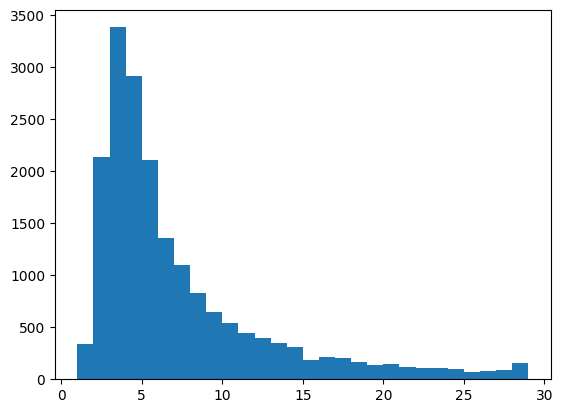

In [ ]:
import matplotlib.pyplot as plt
greedy_embedding_paths_filtered = greedy_embedding_paths[greedy_embedding_paths['path_lengths'] < 30]
plt.hist(greedy_embedding_paths_filtered['path_lengths'], bins=28)

In [26]:
# Make sure the size is the same
filtered_paths_df['full_path_length'] = filtered_paths_df['full_path_length'].apply(lambda x : x+1)
filtered_paths_df['full_path_length'].describe()

count    21646.000000
mean         5.856786
std          1.985092
min          2.000000
25%          4.000000
50%          6.000000
75%          7.000000
max         17.000000
Name: full_path_length, dtype: float64

(array([1745., 3988., 8988., 2822., 2963.,  696.,  331.,   92.,   12.,
           9.]),
 array([ 2. ,  3.5,  5. ,  6.5,  8. ,  9.5, 11. , 12.5, 14. , 15.5, 17. ]),
 <BarContainer object of 10 artists>)

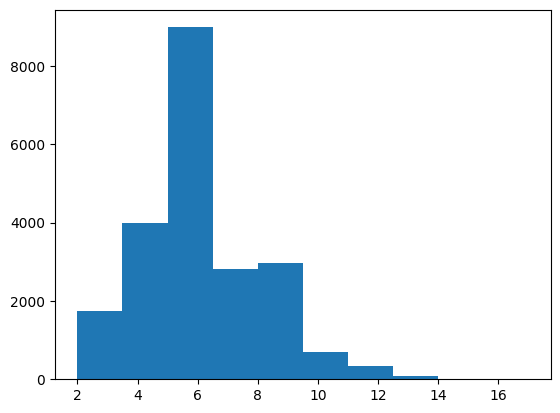

In [27]:
plt.hist(filtered_paths_df['full_path_length'])

# Compare this metric to features

In [28]:
article_features = pd.read_feather("Data/dataframes/article_df_features.feather")

In [29]:
article_features

,article,category,linkTarget,distances,plain_text,num_hyperlinks,num_characters,hyperlink_density,embeddings,vocabulary_richness,incoming_links,pagerank,betweenness_centrality
0,Áedán_mac_Gabráin,[subject.History.British_History.British_Histo...,"[Bede, Columba, Dál_Riata, Great_Britain, Irel...","{'10th_century': 3.0, '11th_century': 3.0, '12...",#copyright\n\nÁedán mac Gabráin\n\n2007 Sch...,11,11612,0.000947,None,0.318346,0,0.000033,0.000000
1,Åland,"[subject.Countries, subject.Geography.European...","[20th_century, Baltic_Sea, Crimean_War, Curren...","{'10th_century': 2.0, '11th_century': 2.0, '12...",#copyright\n\nÅland\n\n2007 Schools Wikiped...,19,17238,0.001102,None,0.376456,0,0.000033,0.000000
2,Édouard_Manet,[subject.People.Artists],"[Absinthe, Beer, Claude_Monet, Diego_Velázquez...","{'10th_century': 3.0, '11th_century': 3.0, '12...",#copyright\n\nÉdouard Manet\n\n2007 Schools...,20,18996,0.001053,None,0.368298,0,0.000033,0.000000
3,Éire,"[subject.Countries, subject.Geography.European...","[Canada, English_language, George_VI_of_the_Un...","{'10th_century': 3.0, '11th_century': 3.0, '12...",#copyright\n\nÉire\n\n2007 Schools Wikipedi...,8,13083,0.000611,None,0.329540,0,0.000033,0.000000
4,Óengus_I_of_the_Picts,[subject.History.British_History.British_Histo...,"[Dál_Riata, Durham, England, Great_Britain, Ir...","{'10th_century': 2.0, '11th_century': 2.0, '12...",#copyright\n\nÓengus I of the Picts\n\n2007...,10,12944,0.000773,None,0.333808,0,0.000033,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4599,Zionism,"[subject.People.Political_People, subject.Reli...","[18th_century, 19th_century, Adolf_Hitler, Alb...","{'10th_century': 2.0, '11th_century': 2.0, '12...",#copyright\n\nZionism\n\n2007 Schools Wikip...,74,62086,0.001192,None,0.247640,25,0.000206,0.000239
4600,Zirconium,[subject.Science.Chemistry.Chemical_elements],"[Aluminium, Arabic_language, Australia, Bicycl...","{'10th_century': 3.0, '11th_century': 3.0, '12...",#copyright\n\nZirconium\n\n2007 Schools Wik...,42,13253,0.003169,None,0.458779,15,0.000088,0.000068
4601,Zoroaster,[subject.People.Religious_figures_and_leaders],"[18th_century, 9th_century, Afghanistan, Age_o...","{'10th_century': 2.0, '11th_century': 2.0, '12...",#copyright\n\nZoroaster\n\n2007 Schools Wik...,28,19726,0.001419,None,0.386653,9,0.000094,0.000056
4602,Zuid-Gelders,"[subject.Geography.European_Geography, subject...","[Brabantian, Dutch_language, East_Flemish, Hol...","{'10th_century': 3.0, '11th_century': 3.0, '12...",#copyright\n\nZuid-Gelders\n\n2007 Schools ...,5,2341,0.002136,None,0.488372,5,0.000087,0.000000


In [30]:
art_greedy_traversal_scores = pd.merge(sum_art_cweights_df, avg_art_weight_df, how="inner", on="article")

In [ ]:
art_greedy_traversal_scores

,n_appearances_x,weighted_sum,n_appearances_y,weighted_avg
article,,,,
Latin_America,83.0,11.394136,83.0,0.489409
Politics,120.0,9.549953,120.0,0.431713
Planet,363.0,-3.961091,363.0,0.341218
Venus,97.0,-6.244870,97.0,0.287750
Thunderstorm,43.0,-2.143451,43.0,0.302282
...,...,...,...,...
"Perth,_Western_Australia",44.0,-9.622627,44.0,0.133434
Zebra,47.0,-1.196430,47.0,0.326674
Apollo_11,30.0,-2.818192,30.0,0.258190


In [32]:
art_greedy_traversal_scores = art_greedy_traversal_scores.drop(columns=['n_appearances_y']).rename({"n_appearances_x":"n_appearances"})


In [ ]:
art_greedy_traversal_scores

,n_appearances_x,weighted_sum,weighted_avg
article,,,
Latin_America,83.0,11.394136,0.489409
Politics,120.0,9.549953,0.431713
Planet,363.0,-3.961091,0.341218
Venus,97.0,-6.244870,0.287750
Thunderstorm,43.0,-2.143451,0.302282
...,...,...,...
"Perth,_Western_Australia",44.0,-9.622627,0.133434
Zebra,47.0,-1.196430,0.326674
Apollo_11,30.0,-2.818192,0.258190


In [34]:
all_article_features_metrics = pd.merge(article_features, art_greedy_traversal_scores, how="inner", on='article')

In [ ]:
all_article_features_metrics

,article,category,linkTarget,distances,plain_text,num_hyperlinks,num_characters,hyperlink_density,embeddings,vocabulary_richness,incoming_links,pagerank,betweenness_centrality,n_appearances_x,weighted_sum,weighted_avg
0,10th_century,[subject.History.General_history],"[11th_century, 9th_century, Algeria, Beer, Bla...","{'10th_century': 0.0, '11th_century': 1.0, '12...",#copyright\n\n10th century\n\n2007 Schools ...,26,5713,0.004551,None,0.582649,65,0.000631,0.000526,46.0,-0.858818,0.333460
1,11th_century,[subject.History.General_history],"[10th_century, 12th_century, 13th_century, 14t...","{'10th_century': 1.0, '11th_century': 0.0, '12...",#copyright\n\n11th century\n\n2007 Schools ...,48,7734,0.006206,None,0.535893,57,0.000545,0.000628,38.0,1.540811,0.392678
2,12th_century,[subject.History.General_history],"[10th_century, 11th_century, 13th_century, 14t...","{'10th_century': 1.0, '11th_century': 1.0, '12...",#copyright\n\n12th century\n\n2007 Schools ...,45,6639,0.006778,None,0.542683,85,0.000718,0.001340,39.0,-0.090464,0.349810
3,13th_century,[subject.History.General_history],"[12th_century, 14th_century, Angola, Arabic_la...","{'10th_century': 2.0, '11th_century': 2.0, '12...",#copyright\n\n13th century\n\n2007 Schools ...,34,6090,0.005583,None,0.611696,84,0.000755,0.000807,66.0,-6.421849,0.254829
4,14th_century,[subject.History.General_history],"[13th_century, 15th_century, Abacus, Aztec, Bl...","{'10th_century': 2.0, '11th_century': 2.0, '12...",#copyright\n\n14th century\n\n2007 Schools ...,31,5846,0.005303,None,0.549539,71,0.000595,0.000507,56.0,-4.555928,0.270774
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1422,Zebra,[subject.Science.Biology.Mammals],"[Africa, Animal, Ethiopia, Extinction, Grevy's...","{'10th_century': 2.0, '11th_century': 3.0, '12...",#copyright\n\nZebra\n\n2007 Schools Wikiped...,12,6487,0.001850,None,0.435091,12,0.000109,0.000457,47.0,-1.196430,0.326674
1423,Zeus,[subject.Religion.Divinities],"[16th_century, Agamemnon, Alexander_the_Great,...","{'10th_century': 2.0, '11th_century': 2.0, '12...",#copyright\n\nZeus\n\n2007 Schools Wikipedi...,29,21592,0.001343,None,0.373088,43,0.000336,0.000692,176.0,-5.939075,0.318385
1424,Zimbabwe,[subject.Geography.African_Geography.African_C...,"[10th_century, 11th_century, 15th_century, 19t...","{'10th_century': 1.0, '11th_century': 1.0, '12...",#copyright\n\nZimbabwe\n\n2007 Schools Wiki...,63,25255,0.002495,None,0.368183,86,0.000456,0.000868,67.0,-1.051859,0.336431
1425,Zinc,[subject.Science.Chemistry.Chemical_elements],"[Aluminium, Ancient_Rome, Argon, Australia, Be...","{'10th_century': 3.0, '11th_century': 3.0, '12...",#copyright\n\nZinc\n\n2007 Schools Wikipedi...,36,21264,0.001693,None,0.392628,68,0.000493,0.000851,86.0,-2.234417,0.326148


In [36]:
from src.scripts.correlation_processing import *
from src.utils.plots import *

In [37]:
all_article_features_metrics.columns

Index(['article', 'category', 'linkTarget', 'distances', 'plain_text',
       'num_hyperlinks', 'num_characters', 'hyperlink_density', 'embeddings',
       'vocabulary_richness', 'incoming_links', 'pagerank',
       'betweenness_centrality', 'n_appearances_x', 'weighted_sum',
       'weighted_avg'],
      dtype='object')

In [41]:
correlate_attributes(
    all_article_features_metrics,
    attributes=[
        "num_hyperlinks",
        "num_characters",
        "hyperlink_density",
        "vocabulary_richness",
        'pagerank',
        'betweenness_centrality'
    ],
    scores=[
        'weighted_sum',
        'weighted_avg'
    ]
)

{'weighted_sum': num_hyperlinks            0.541427
 num_characters            0.205808
 hyperlink_density         0.158215
 vocabulary_richness      -0.160011
 pagerank                  0.793598
 betweenness_centrality    0.857898
 dtype: float64,
 'weighted_avg': num_hyperlinks            0.471399
 num_characters            0.231036
 hyperlink_density         0.131587
 vocabulary_richness      -0.266103
 pagerank                  0.548084
 betweenness_centrality    0.404055
 dtype: float64}

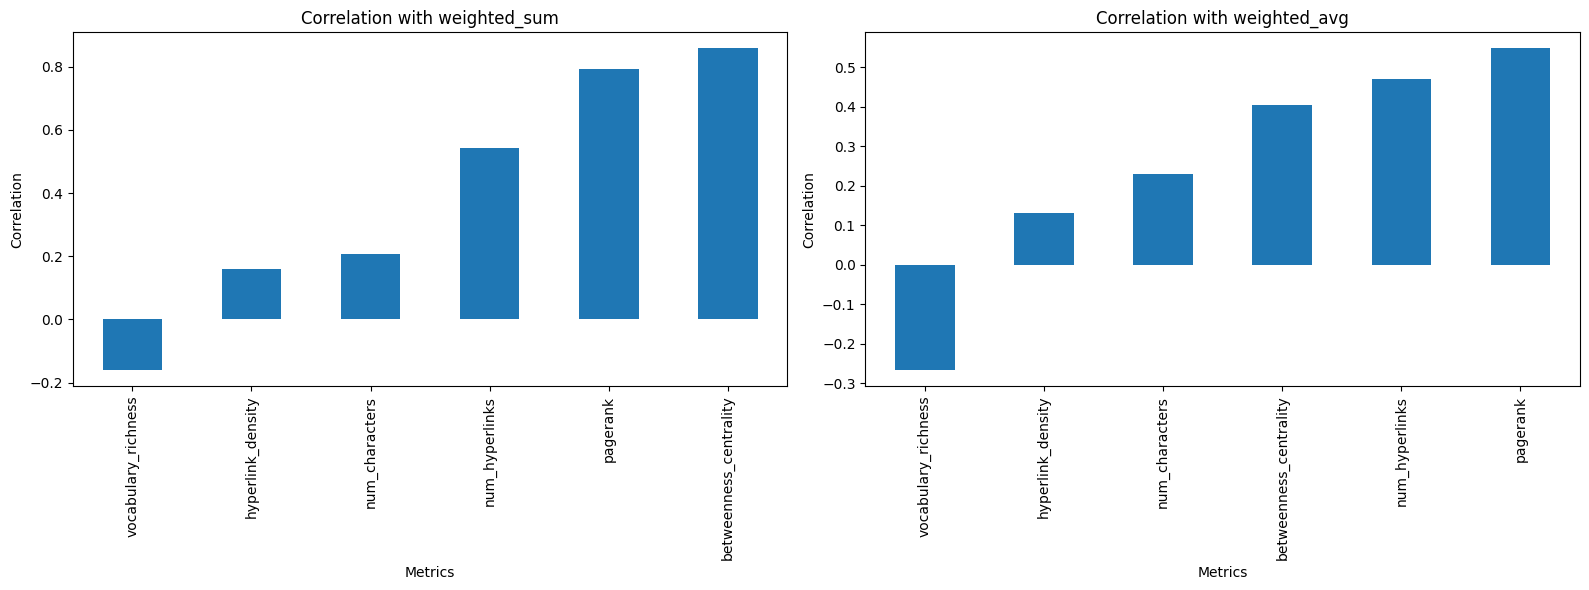

In [ ]:
plot_correlations(correlate_attributes(
    all_article_features_metrics,
    attributes=[
        "num_hyperlinks",
        "num_characters",
        "hyperlink_density",
        "vocabulary_richness",
        'pagerank',
        'betweenness_centrality'
    ],
    scores=[
        'weighted_sum',
        'weighted_avg'
    ]
))

In [46]:
index_lookup


{'Monopoly_(game)': 0,
 'Hurricane_Ivan': 1,
 'Felice_Beato': 2,
 'Florence_Nightingale': 3,
 'Force': 4,
 'Bushpig': 5,
 'Magma': 6,
 'Drought': 7,
 'Tree_frog': 8,
 'Symmetry': 9,
 'Toy': 10,
 'John_Dee': 11,
 'Benzene': 12,
 'Austria': 13,
 'Joel_Brand': 14,
 'Wars_of_the_Roses': 15,
 'Argyle_diamond_mine': 16,
 'Prospecting': 17,
 'Schrödinger_equation': 18,
 'Wheat': 19,
 'Gold_standard': 20,
 'Andy_Warhol': 21,
 'Iron_Maiden': 22,
 'Lawrencium': 23,
 'Peter_Grimes': 24,
 'Zinc': 25,
 'List_of_South_American_countries': 26,
 'Jacques_Cartier': 27,
 'The_Count_of_Monte_Cristo': 28,
 'Black_Robin': 29,
 'Baltic_Sea': 30,
 'Neoclassicism': 31,
 'Second_Congo_War': 32,
 'Battle_of_Britain': 33,
 'Creation-evolution_controversy': 34,
 'Whale': 35,
 'Jerry_Fodor': 36,
 'Ordinal_number': 37,
 'Gilles_Villeneuve': 38,
 'Hurricane_Camille': 39,
 'Willem_Barents': 40,
 'Fire': 41,
 'Battle_of_Badr': 42,
 'Ice_sheet': 43,
 'Porto-Novo': 44,
 'Telecommunication': 45,
 'Local_community': 46,
 

In [50]:
distance_matrix.shape

(4604, 4604)

: 